# Step 0 : Implementation of required libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import emoji
from wordcloud import WordCloud     # text visualisation library
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import numpy as np

2024-11-05 10:45:59.756299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 10:45:59.770725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 10:45:59.774629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 10:45:59.783942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 10:46:00.586016: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Embedding,LSTM, Input, Dropout, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Step 1 : Data Preprocessing

<h4> Loading the Data </h4>

In [ ]:
# from the data description we get the column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Import the CSV file with specified column names
data = pd.read_csv("data.csv", encoding="UTF-8", names=column_names)

# We only need the 2 columns ['target','text']
data = data[['target','text']]
# we can print the count of positive values and negative ones (0 : negative, 4 : positive)
print(data['target'].value_counts())

target
0    800000
4    800000
Name: count, dtype: int64


<h4> Data Cleaning : </h4>

For cleaning data, we did it several times to see the data shape and the words that are left in each text, after trying different methods we concluded that the most effective way is : 
- use a Lemmetizer to get the stem of each word
- delete and remove some words that are used multiple time that do not have a clear meaning like "quot"
- replace some abreviations like "u" by "you" and "some1" by "someone" to have a better dictionnary

In [7]:
# Define the replacement dictionary
replacement_dict = {
    " some1 ": " someone ",
    " u ": " you ",
    " r ": " are ",
    " 4 ": " for ",
    " 2 ": " to ",
}

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_data(text, lang):
    # Convert text to lowercase and demojize emojis
    text = text.lower()
    text = str(emoji.demojize(text))
    
    # Remove URLs and mentions
    text = re.sub(r'(http\S+)|(@[^ ]*)', ' ', text)
    
    # Replace non-word characters with spaces and remove extra spaces
    text = re.sub("[^\w]", " ", text)
    text = re.sub(r'\s+', ' ', text)
    
    # Apply dictionary-based replacements
    for key, value in replacement_dict.items():
        text = text.replace(key, value)   
    
    # Tokenize the text
    text = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words(lang))
    stop_words.add("amp")
    stop_words.add("quot")
    stop_words.add("lol")
    stop_words.add("haha")
    text = [word for word in text if word.lower() not in stop_words]
    
    # Lemmatize the words
    pos_tags = nltk.pos_tag(text)
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    # Join the lemmatized words into a single string
    result = ' '.join(text)
    
    return result

# Helper function to get WordNet POS tags from treebank POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

# necessary downloads for the function
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/aymen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aymen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aymen/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/aymen/nltk_data...


KeyboardInterrupt: 

In [ ]:
import os
# we check if we did the preprocessing already to save time
if not os.path.exists("clean_data.csv"):
    print("Cleaning data...")
    data['text'] = data['text'].apply(lambda x: clean_data(x,"english"))    # it takes more than 30min
    print("Cleaning data : Done!\n")
    data = data[data['text'].notna()]
    data.to_csv("clean_data.csv", index=False)      # saving the new clean preprocessed data
    print("New processed data saved to clean_data.csv")
else:
    # if we already processed the data we directly use the one already treated
    data = pd.read_csv("clean_data.csv")
    print("Data directly loaded from clean_data.csv")


Data directly loaded from clean_data.csv


<h4> Vocabulary Construction </h4>

In [ ]:
from collections import Counter

if not os.path.exists("vocabulary_and_frequencies.txt"):
    # Flatten the list of text data into a single list of words
    words = []
    for i,text in enumerate(data['text']):
        try: 
            for word in text.split():
                if word.isnumeric():
                    words.append("<NUM>")
                else:
                    words.append(word)
        except: 
            continue
    
    # Calculate word frequencies using Counter
    word_freq = Counter(words)

    # Save vocabulary and frequencies to a file
    with open("vocabulary_and_frequencies.txt", "w", encoding="utf-8") as f:
        for word, freq in word_freq.items():
            f.write(f"{word}: {freq}\n")

    print("Vocabulary and frequencies saved to vocabulary_and_frequencies.txt")
else:
    print("Charging the vocabulary from already saved file 'vocabulary_and_frequencies.txt'")
    word_freq = {}
    with open("vocabulary_and_frequencies.txt", "r", encoding="utf-8") as f:
        for i in f:
            words = i.replace("\n","").split(": ")
            word_freq[words[0]] = int(words[1])
            

Charging the vocabulary from already saved file 'vocabulary_and_frequencies.txt'


In [ ]:
# Display word frequencies example : 
i = 0
for key,val in word_freq.items():
    print(f"word '{key}' \thas frequency of : {val}")
    i += 1
    if i == 10:
        break

word 'awww' 	has frequency of : 5619
word 'bummer' 	has frequency of : 1571
word 'shoulda' 	has frequency of : 358
word 'get' 	has frequency of : 180712
word 'david' 	has frequency of : 2532
word 'carr' 	has frequency of : 80
word 'third' 	has frequency of : 846
word 'day' 	has frequency of : 106296
word 'upset' 	has frequency of : 2933
word 'update' 	has frequency of : 8499


<h4> Creating our dictionnary </h4>

We need to build our proper dictionnary so we can use only the words that are often used

In [ ]:
# we set our dictionary to empty in the beginning
word_dict = {}

# we add 2 attributes that will represent:
word_dict["<UNK>"] = 0  # unknown words : that will be ignored because their frequency is too low
word_dict["<NUM>"] = 1  # Numbers : it will represent if there are numbers in the text treated
indice = 0
for i, word in enumerate(word_freq.items()):
    if word[1] > 2000:      # we set the minimum frequency of a word to be : 2000 
        if word[0] not in word_dict:
            word_dict[word[0]] = indice+2
            indice += 1

# our dictionnary will have : 
print(f"Our dictionnary contains : {len(word_dict)} words")

Our dictionnary contains : 797 words


In [ ]:
# Display words from our dictionnary example : 
i = 0
for key,val in word_dict.items():
    print(f"word '{key}' \thas index of : {val}")
    i += 1
    if i == 10:
        break

word '<UNK>' 	has index of : 0
word '<NUM>' 	has index of : 1
word 'awww' 	has index of : 2
word 'get' 	has index of : 3
word 'david' 	has index of : 4
word 'day' 	has index of : 5
word 'upset' 	has index of : 6
word 'update' 	has index of : 7
word 'facebook' 	has index of : 8
word 'might' 	has index of : 9


<h4>Extraction of caracteristics</h4>

In [ ]:
indices_used = []
for text in data['text']:
    new_set = [0 for _ in range(len(word_dict))]
    try: 
        for word in text.split():
            if word.isnumeric() :
                new_set[word_dict['<NUM>']] = 1
            elif word in word_dict.keys():
                new_set[word_dict[word]] = 1
            else:
                new_set[word_dict['<UNK>']] = 1
        indices_used.append(new_set)
    except: 
        indices_used.append(new_set)
            

Testing how our dictionnary will work

In [ ]:
print(word_dict)
L = word_dict.values()
print(data['text'][1])
print()
print(indices_used[1])
for indice,mot in enumerate(indices_used[1]):
    if mot == 1:
        print(f"{list(word_dict.keys())[indice]} : 1", end=';')
    else:
        print(f"{list(word_dict.keys())[indice]} : 0", end=';')
print()

{'<UNK>': 0, '<NUM>': 1, 'awww': 2, 'get': 3, 'david': 4, 'day': 5, 'upset': 6, 'update': 7, 'facebook': 8, 'might': 9, 'cry': 10, 'school': 11, 'today': 12, 'also': 13, 'many': 14, 'time': 15, 'ball': 16, 'save': 17, 'rest': 18, 'go': 19, 'whole': 20, 'body': 21, 'feel': 22, 'like': 23, 'mad': 24, 'see': 25, 'need': 26, 'hug': 27, 'hey': 28, 'long': 29, 'yes': 30, 'rain': 31, 'bit': 32, 'fine': 33, 'thanks': 34, 'nope': 35, 'break': 36, 'city': 37, 'watch': 38, 'think': 39, 'count': 40, 'idk': 41, 'either': 42, 'never': 43, 'talk': 44, 'anymore': 45, 'would': 46, 'first': 47, 'really': 48, 'though': 49, 'wish': 50, 'miss': 51, 'hurt': 52, 'film': 53, 'cut': 54, 'ahh': 55, 'ive': 56, 'always': 57, 'want': 58, 'love': 59, 'oh': 60, 'dear': 61, 'drink': 62, 'much': 63, 'do': 64, 'one': 65, 'friend': 66, 'call': 67, 'ask': 68, 'meet': 69, 'sigh': 70, 'cake': 71, 'week': 72, 'hop': 73, 'class': 74, 'tomorrow': 75, 'hate': 76, 'wake': 77, 'people': 78, 'sleep': 79, 'im': 80, 'sad': 81, 'ok'

<h3>We save our binary representation in the DataFrame in new column</h3>

In [ ]:
data['binaire'] = indices_used
positive_data = data[data['target'] == 4]
negative_data = data[data['target'] == 0]
print(data['target'].value_counts())

target
0    796097
4    795916
Name: count, dtype: int64


Representing data values :

In [ ]:
positive_data

,target,text,binaire
796097,4,love guy best,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796098,4,im meet one besties tonight cant wait girl talk,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796099,4,thanks twitter add sunisa get meet hin show dc...,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796100,4,sick really cheap hurt much eat real food plus...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796101,4,effect everyone,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1592008,4,woke school best feeling ever,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1592009,4,thewdb com cool hear old walt interview,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1592010,4,ready mojo makeover ask detail,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1592011,4,happy 38th birthday boo alll time tupac amaru ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
negative_data

,target,text,binaire
0,0,awww bummer shoulda get david carr third day,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,upset update facebook texting might cry result...,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,0,dive many time ball manage save 50 rest go bound,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,0,whole body feel itchy like fire,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,behave mad see,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
796092,0,sick spending day lay bed listen,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796093,0,gmail,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796094,0,rest peace farrah sad,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
796095,0,sound like rival flag ad much though,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<h4>Representing the data we have</h4>

- Bar plot : representation the count of our data

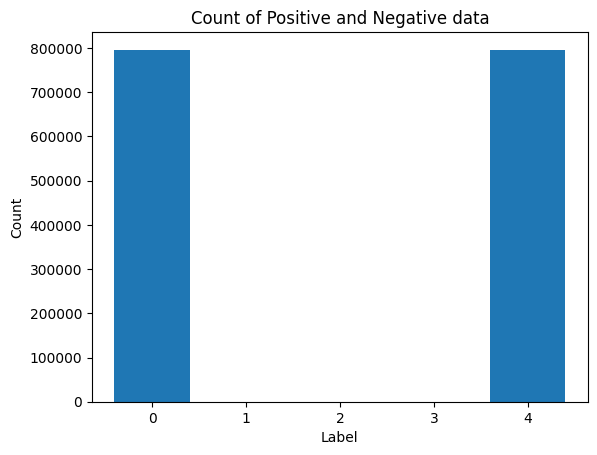

In [ ]:
label_counts = data['target'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts)

# Set labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Positive and Negative data')

# Show the plot
plt.show()

- Word Cloud : it will represent the most used words in the positive data and the negative data

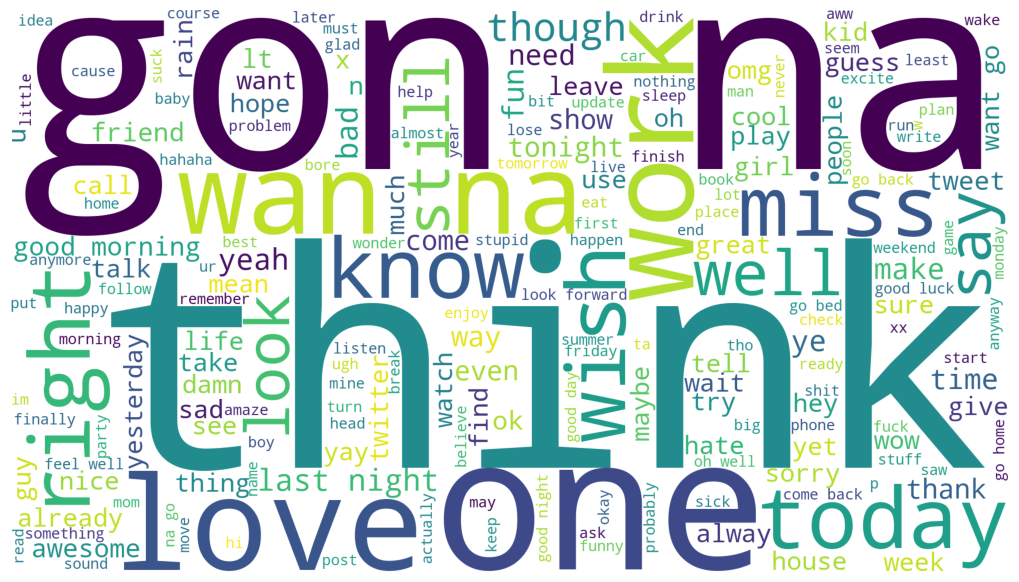

In [ ]:
all_text = ' '.join(data['text'].to_list())
worldcloud = WordCloud(width=1920,height=1080,background_color='white').generate(all_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(worldcloud)
plt.axis('off')     # to not show the axis
plt.tight_layout(pad=0)
plt.show()

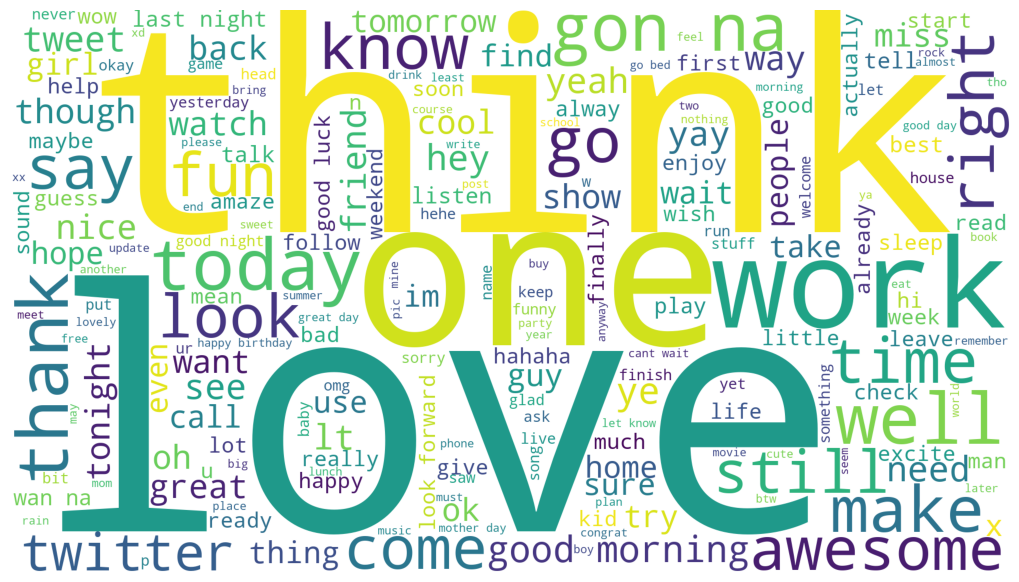

In [ ]:
all_text = ' '.join(positive_data['text'].to_list())
worldcloud = WordCloud(width=1920,height=1080,background_color='white').generate(all_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(worldcloud)
plt.axis('off')     # to not show the axis
plt.tight_layout(pad=0)
plt.show()

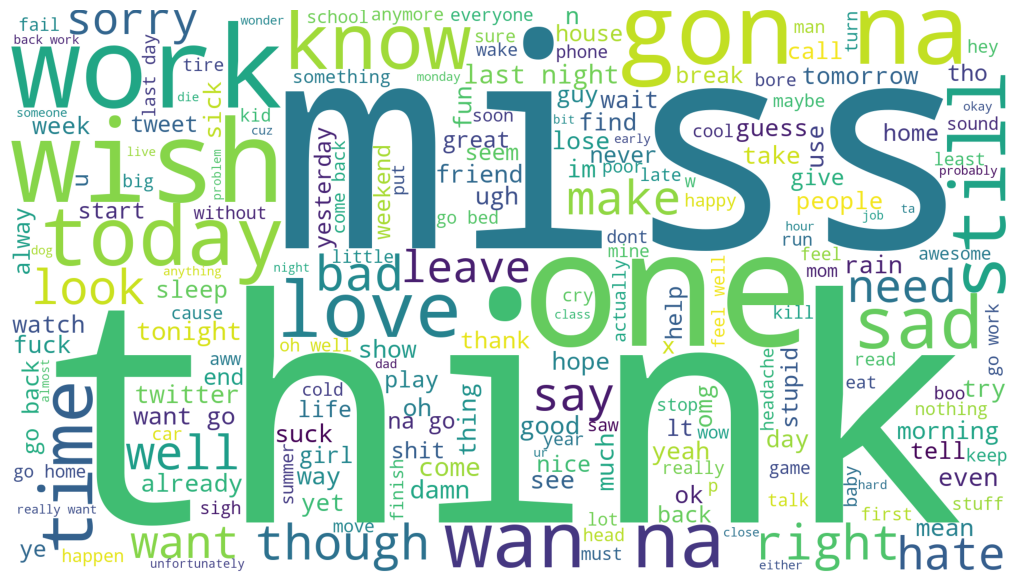

In [ ]:
all_text = ' '.join(negative_data['text'].to_list())
worldcloud = WordCloud(width=1920,height=1080,background_color='white').generate(all_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(worldcloud)
plt.axis('off')     # to not show the axis
plt.tight_layout(pad=0)
plt.show()

# Step 2 : training the models

- Dividing the training data and testing data

In [ ]:
text_features_array = np.array(data['binaire'].tolist())

labels = data['target'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(text_features_array, encoded_labels, test_size=0.2)


In [ ]:
print(x_train.shape)
print(y_train.shape)


(1273610, 797)
(1273610,)


<h4>Sequential Neural Network</h4>

In [ ]:
input_layer_size = len(word_dict)
model_sequential = Sequential()

# adding the layers 
model_sequential.add(Input(shape=(input_layer_size,)))
model_sequential.add(Dense(units=64,activation='relu'))
model_sequential.add(Dense(units=32,activation='relu'))
model_sequential.add(Dense(units=1,activation='sigmoid'))

model_sequential.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                51072     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53185 (207.75 KB)
Trainable params: 53185 (207.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_sequential.fit(x_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
127361/127361 [==============================] - 119s 927us/step - loss: 0.5174 - accuracy: 0.7395
Epoch 2/5
127361/127361 [==============================] - 116s 915us/step - loss: 0.5062 - accuracy: 0.7480
Epoch 3/5
127361/127361 [==============================] - 119s 936us/step - loss: 0.5023 - accuracy: 0.7512
Epoch 4/5
127361/127361 [==============================] - 120s 943us/step - loss: 0.5001 - accuracy: 0.7530
Epoch 5/5
127361/127361 [==============================] - 119s 935us/step - loss: 0.4982 - accuracy: 0.7541


In [ ]:
loss, accuracy = model_sequential.evaluate(x_test, y_test)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

9951/9951 [==============================] - 9s 879us/step - loss: 0.5094 - accuracy: 0.7465
Loss :  0.5093564391136169
Accuracy :  0.7464690804481506


<h4>LSTM : Deep Learning</h4>

In [ ]:
timesteps = 1
x_train_reshaped = x_train.reshape((x_train.shape[0], timesteps, x_train.shape[1]))
x_test_reshaped = x_test.reshape((x_test.shape[0], timesteps, x_test.shape[1]))

In [ ]:
print(x_train_reshaped.shape)
print(y_train.shape)


(1273923, 1, 658)
(1273923,)


In [ ]:

timesteps = 1
#filename = 'LSTM_model.keras'
max_acc = 0

# Définition du modèle avec des techniques de régularisation pour éviter le surapprentissage
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, x_train.shape[1])))
model.add(Dropout(0.5))  # Ajout d'une couche Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))  # Ajout d'une autre couche Dropout
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Callbacks pour Early Stopping et pour sauvegarder le meilleur modèle
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint(filename, save_best_only=True, monitor='val_loss')

# Entraînement du modèle avec validation
with tf.device('/GPU:0'):
    history = model.fit(
        x_train_reshaped, y_train, 
        epochs=50,  # Augmentation du nombre d'époques pour permettre le callback EarlyStopping d'agir
        batch_size=200, 
        validation_split=0.2, 
    )

# Chargement du meilleur modèle sauvegardé
# model.load_weights(filename)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       402,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,265 (1.57 MB)

 Trainable params: 411,265 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.7119 - loss: 0.6158 - val_accuracy: 0.7327 - val_loss: 0.5324
Epoch 2/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7309 - loss: 0.5356 - val_accuracy: 0.7346 - val_loss: 0.5270
Epoch 3/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.7346 - loss: 0.5314 - val_accuracy: 0.7368 - val_loss: 0.5245
Epoch 4/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.7370 - loss: 0.5280 - val_accuracy: 0.7379 - val_loss: 0.5215
Epoch 5/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.7398 - loss: 0.5252 - val_accuracy: 0.7398 - val_loss: 0.5196
Epoch 6/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.7421 - loss: 0.5229 - val_accuracy: 0.7407 - val_loss: 0.5197
Epoch 7/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7436 - loss: 0.5202 - val_accuracy: 0.7398 - val_loss: 0.5215
Epoch 8/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7448 - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5096/5096 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.7674 - loss: 0.4897 - val_accuracy: 0.7434 - val_loss: 0.5207
Epoch 34/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7677 - loss: 0.4885 - val_accuracy: 0.7439 - val_loss: 0.5205
Epoch 35/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7679 - loss: 0.4887 - val_accuracy: 0.7439 - val_loss: 0.5217
Epoch 36/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7684 - loss: 0.4878 - val_accuracy: 0.7443 - val_loss: 0.5224
Epoch 37/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7684 - loss: 0.4874 - val_accuracy: 0.7435 - val_loss: 0.5227
Epoch 38/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7698 - loss: 0.4854 - val_accuracy: 0.7432 - val_loss: 0.5221
Epoch 39/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7701 - loss: 0.4855 - val_accuracy: 0.7434 - val_loss: 0.5262
Epoch 40/50
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7709 - loss: 0.483

In [ ]:
loss, accuracy = model.evaluate(x_test_reshaped, y_test)
print(loss)
print(accuracy)

9953/9953 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7421 - loss: 0.5286
0.5288407802581787
0.7424587607383728


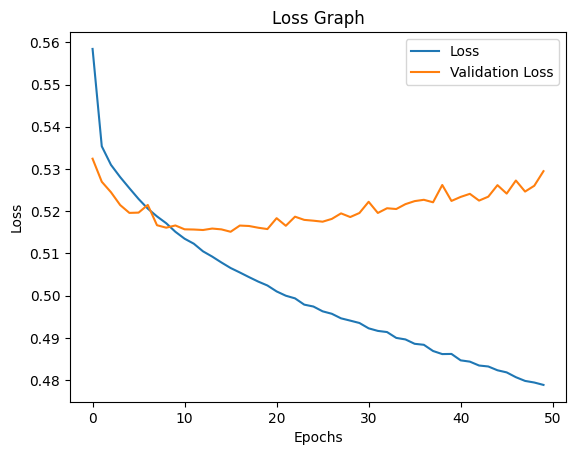

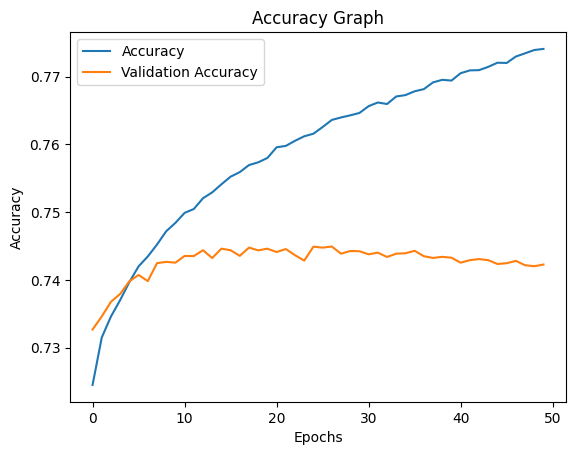

In [ ]:
# prompt: plot the loss and accuracy graph 

# Plot the loss and accuracy graphs
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<h4>SVM</h4>

In [ ]:
from sklearn import svm
SVMmodel = svm.SVC().fit(x_train, y_train)

MemoryError: Unable to allocate 7.56 GiB for an array with shape (1273610, 797) and data type float64

In [ ]:
y_pred = SVMmodel.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

<h4>Logistic Regression</h4>

In [ ]:
from sklearn.linear_model import LogisticRegression
RegressionLogisticmodel = LogisticRegression().fit(x_train, y_train)

In [ ]:
y_pred = (RegressionLogisticmodel.predict(x_test))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7361739682100985
              precision    recall  f1-score   support

           0       0.76      0.69      0.72    159102
           1       0.72      0.78      0.75    159301

    accuracy                           0.74    318403
   macro avg       0.74      0.74      0.74    318403
weighted avg       0.74      0.74      0.74    318403



<h4>Random Forest</h4>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RandomForestmodel = RandomForestClassifier().fit(x_train, y_train)

In [ ]:
y_pred = (RandomForestmodel.predict(x_test))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7272607356086469
              precision    recall  f1-score   support

           0       0.73      0.71      0.72    159102
           1       0.72      0.74      0.73    159301

    accuracy                           0.73    318403
   macro avg       0.73      0.73      0.73    318403
weighted avg       0.73      0.73      0.73    318403

